In [1]:
import importlib
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import nue as nue
importlib.reload(nue)

<module 'nue' from '/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py'>

# notes

we're using cheat pandora! 

In [24]:
nue_file = "/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_caf_data.df"
nue_hdr_df_0 = pd.read_hdf(nue_file,key="hdr")
nue_nuu_df_0 = pd.read_hdf(nue_file,key="mcnu")
nue_nuprim_df_0 = pd.read_hdf(nue_file,key="mcnuprim")
nue_slctrk_df_0 = pd.read_hdf(nue_file,key="slctrk")
nue_slcshw_df_0 = pd.read_hdf(nue_file,key="slcshw")

nu_idx_set = ["ntuple","entry","nu_index"]
slc_idx_set = ["ntuple","entry","rec.slc__index"]
evt_idx_set = ["ntuple","entry"]

nue_hdr_df = nue.flatten_df(nue_hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt","rec_hdr_pot"]].rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"})
nue_sub_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_opt0.root:opt0finder/flash_match_tree").arrays(['run','subrun','event'],library="pd").drop_duplicates()
nue_sub_df = nue_hdr_df.merge(nue_sub_opt0_df,on=["run","subrun",'event'],how="inner")

In [25]:
# make nue dataframes
nue_nuprim_df = nue_nuprim_df_0.copy()

whereFV = nue.maskTrueVtxFv(nue_nuprim_df)
whereSig = ((nue_nuprim_df.iscc==1) & (abs(nue_nuprim_df.pdg)==12) & (abs(nue_nuprim_df.prim.pdg)==11))# & (nue_nuprim_df.prim.startE > 0.2) )
nue_nuprim_df = nue.defineBackground(nue_nuprim_df)
nue_nuprim_df["signal"] = np.where(whereFV & whereSig,0,nue_nuprim_df["signal"])

nue_nu_df = nue_nuprim_df.loc[:,:,:,0]
nue_nu_df = nue.flatten_df(nue_nu_df)
nue_nu_df["nu_index"] = nue_nu_df["rec.mc.nu__index"]

# get the dataframe that contains the counts of each PDG per event 
nue_pdg_counts = nue.getPDGCounts(nue_nuprim_df)

# merge the pdg counts into the full nue_nu_df 
nue_nu_df = nue_nu_df.merge(nue_pdg_counts,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# get slcpfp dataframe 
slcpfp_nue_df = nue.getPFP(nue_slcshw_df_0,nue_slctrk_df_0,cheat=True)

# merge slcpfp with neutrino events 
slcpfp_nue_nu_df = slcpfp_nue_df.merge(nue_nu_df,on=nu_idx_set,how="left")
slcpfp_nue_nu_df["signal"] = np.where(slcpfp_nue_df.slc_tmatch_idx==-999,5,slcpfp_nue_nu_df['signal'])

for this sample, intrnue + cosmics, we can break-down the components of our events into: 
- 1eNp0pi FV (signal)
- numuCC FV
- nue NC, FV 
- other nueCC, FV 
- dirt (outside FV)

In [26]:
nue_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_opt0.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
nue_opt0_df["frac_pe"] = (nue_opt0_df.hypo_pe - nue_opt0_df.flash_pe)/nue_opt0_df.flash_pe
nue_opt0_df = nue_opt0_df[nue_opt0_df.pfpid != -1]

# for multiple matches per slice, take the match with the best score
nue_opt0_df = nue_opt0_df[(nue_opt0_df.score == nue_opt0_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max))]
nue_hdr_opt0_df = nue_sub_df[["ntuple","entry","run","subrun","event"]].drop_duplicates().merge(nue_opt0_df,how="left",on=["run","subrun","event"])
slcpfp_nue_nu_df = slcpfp_nue_nu_df.merge(nue_hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="left")

In [27]:
slc_opt0_nu_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx != -999 & run>0" )
slc_opt0_nu_df

,ntuple,entry,rec.slc__index,rec.slc.reco.pfp__index,slc_is_clear_cosmic,slc_vertex_x,slc_vertex_y,slc_vertex_z,slc_self,slc_tmatch_eff,...,prim_exit_count,prim_cont,run,subrun,event,tpc,score,hypo_pe,flash_pe,frac_pe
2,0,0,1,0,0,74.239891,196.687943,370.607269,17,0.895612,...,0.0,True,1.0,1.0,1.0,1.0,25048.647045,51170.125713,76623.102525,-0.332184
25,0,1,2,0,0,-170.924515,-175.894073,387.306732,85,0.713153,...,0.0,True,1.0,1.0,2.0,0.0,18307.083249,63263.126074,69353.594350,-0.087818
97,0,2,0,0,0,152.904449,67.524643,135.521576,50,0.807931,...,0.0,True,1.0,1.0,3.0,1.0,4698.287897,83640.147875,76227.619300,0.097242
145,0,3,0,0,0,-57.189709,15.841514,201.502365,81,0.859829,...,0.0,True,1.0,1.0,4.0,0.0,16908.475532,261838.849966,213636.526475,0.225628
229,0,4,2,0,0,51.097004,203.682495,287.160034,51,0.974380,...,3.0,False,1.0,1.0,5.0,1.0,5268.240950,9336.121368,11664.359150,-0.199603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542817,0,9986,0,0,0,-91.040886,-114.569496,430.325806,22,0.957104,...,1.0,False,1.0,227.0,7.0,0.0,19424.484551,43114.102167,34573.981425,0.247010
542837,0,9987,1,0,0,-83.575424,-114.044914,373.976135,84,0.941868,...,0.0,True,1.0,227.0,8.0,0.0,39018.814653,90810.894217,74880.232650,0.212749
542921,0,9988,1,0,0,-177.598267,-131.827942,426.960724,50,0.947090,...,2.0,False,1.0,227.0,9.0,0.0,5690.855138,40025.719819,38210.341650,0.047510
542963,0,9989,0,0,0,143.518600,-184.869766,132.446045,54,0.928316,...,1.0,False,1.0,227.0,10.0,1.0,456.588635,81229.059740,92064.029400,-0.117690


In [28]:
slc_opt0_co_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx == -999 & run>0" )
slc_opt0_co_df

,ntuple,entry,rec.slc__index,rec.slc.reco.pfp__index,slc_is_clear_cosmic,slc_vertex_x,slc_vertex_y,slc_vertex_z,slc_self,slc_tmatch_eff,...,prim_exit_count,prim_cont,run,subrun,event,tpc,score,hypo_pe,flash_pe,frac_pe
0,0,0,0,0,0,0.565328,-203.647247,447.391571,18,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,30.004604,23701.236398,76623.102525,-0.690678
31,0,1,3,0,0,-12.060795,12.126836,2.116520,83,NaN,...,NaN,NaN,1.0,1.0,2.0,0.0,15.735860,35764.903741,69353.594350,-0.484311
34,0,1,4,0,0,-61.960625,168.747650,429.664948,84,NaN,...,NaN,NaN,1.0,1.0,2.0,0.0,18.894335,6429.064830,69353.594350,-0.907300
100,0,2,1,0,0,142.862701,191.943909,223.065872,51,NaN,...,NaN,NaN,1.0,1.0,3.0,1.0,35.628579,6182.659077,76227.619300,-0.918892
103,0,2,2,0,0,-1.478589,195.227707,413.226105,52,NaN,...,NaN,NaN,1.0,1.0,3.0,0.0,187.916952,4582.691996,4864.408800,-0.057914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542918,0,9988,0,0,0,-162.010406,-68.571739,5.055321,51,NaN,...,NaN,NaN,1.0,227.0,9.0,0.0,2.555709,25216.507489,38210.341650,-0.340061
542925,0,9988,2,0,0,83.278412,175.582367,230.611618,49,NaN,...,NaN,NaN,1.0,227.0,9.0,1.0,8.379575,14314.385751,93.287075,152.444470
542968,0,9989,1,0,0,157.255920,203.732040,34.176521,57,NaN,...,NaN,NaN,1.0,227.0,10.0,1.0,10.387472,4597.084238,92064.029400,-0.950066
542970,0,9989,2,0,0,44.397892,-204.033905,485.725555,56,NaN,...,NaN,NaN,1.0,227.0,10.0,1.0,20.130858,2451.335408,92064.029400,-0.973374


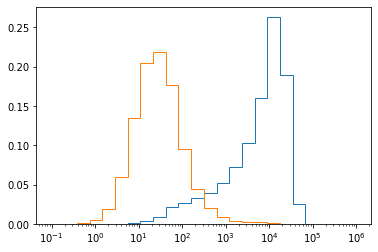

In [29]:
bins = np.logspace(-1,6,25)
nu_weights = np.ones_like(slc_opt0_nu_df.score)/len(slc_opt0_nu_df.score)
co_weights = np.ones_like(slc_opt0_co_df.score)/len(slc_opt0_co_df.score)
plt.hist(slc_opt0_nu_df.score,bins=bins,histtype="step",weights=nu_weights)
plt.hist(slc_opt0_co_df.score,bins=bins,histtype="step",weights=co_weights)
plt.xscale('log')
plt.show()

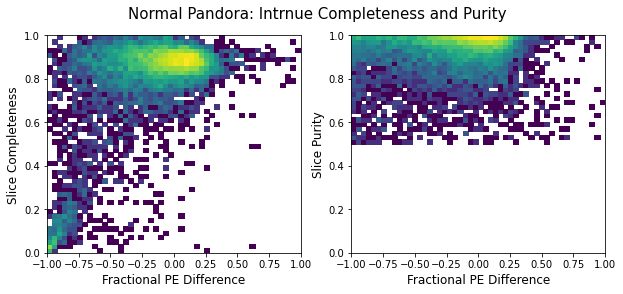

In [30]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(slc_opt0_nu_df.frac_pe
           ,slc_opt0_nu_df.slc_tmatch_eff
           ,bins=[np.linspace(-1,1,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[0].set_xlabel("Fractional PE Difference",fontsize=12)
axes[0].set_ylabel("Slice Completeness",fontsize=12)

axes[1].hist2d(slc_opt0_nu_df.frac_pe
           ,slc_opt0_nu_df.slc_tmatch_pur
           ,bins=[np.linspace(-1,1,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[1].set_xlabel("Fractional PE Difference",fontsize=12)
axes[1].set_ylabel("Slice Purity",fontsize=12)
plt.suptitle("Normal Pandora: Intrnue Completeness and Purity",fontsize=15)
plt.show()

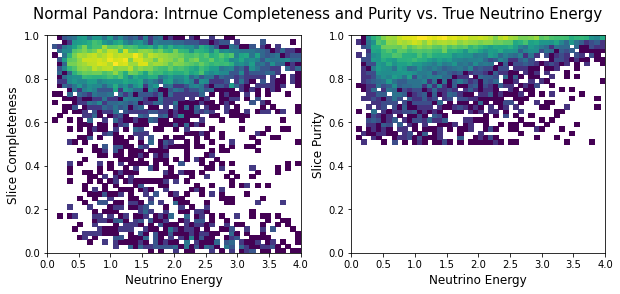

In [32]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(slc_opt0_nu_df.E
           ,slc_opt0_nu_df.slc_tmatch_eff
           ,bins=[np.linspace(0,4,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[0].set_xlabel("Neutrino Energy",fontsize=12)
axes[0].set_ylabel("Slice Completeness",fontsize=12)

axes[1].hist2d(slc_opt0_nu_df.E
           ,slc_opt0_nu_df.slc_tmatch_pur
           ,bins=[np.linspace(0,4,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[1].set_xlabel("Neutrino Energy",fontsize=12)
axes[1].set_ylabel("Slice Purity",fontsize=12)
plt.suptitle("Normal Pandora: Intrnue Completeness and Purity vs. True Neutrino Energy",fontsize=15)
plt.show()

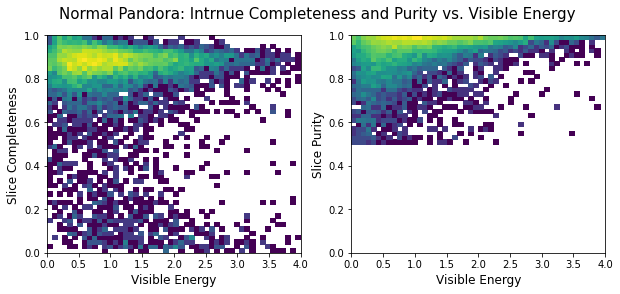

In [33]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(slc_opt0_nu_df.total_prim_depE
           ,slc_opt0_nu_df.slc_tmatch_eff
           ,bins=[np.linspace(0,4,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[0].set_xlabel("Visible Energy",fontsize=12)
axes[0].set_ylabel("Slice Completeness",fontsize=12)

axes[1].hist2d(slc_opt0_nu_df.total_prim_depE
           ,slc_opt0_nu_df.slc_tmatch_pur
           ,bins=[np.linspace(0,4,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[1].set_xlabel("Visible Energy",fontsize=12)
axes[1].set_ylabel("Slice Purity",fontsize=12)
plt.suptitle("Normal Pandora: Intrnue Completeness and Purity vs. Visible Energy",fontsize=15)
plt.show()

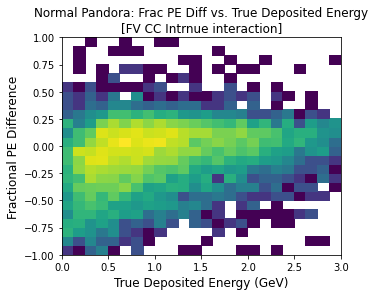

In [9]:
# look only at slices with high completeness 
fig = plt.figure(figsize=(5,4))
this_df = slc_opt0_nu_df.query("slc_tmatch_eff > 0.8")
# fig, axes = plt.subplots(1,2,figsize=(10,4))
plt.hist2d(this_df.total_prim_depE
           ,this_df.frac_pe
           ,bins=[np.linspace(0,3,25),np.linspace(-1,1,25)]
           ,norm=mpl.colors.LogNorm()
           )
plt.xlabel("True Deposited Energy (GeV)",fontsize=12)
plt.ylabel("Fractional PE Difference",fontsize=12)

plt.title("Normal Pandora: Frac PE Diff vs. True Deposited Energy\n[FV CC Intrnue interaction]")
plt.show()

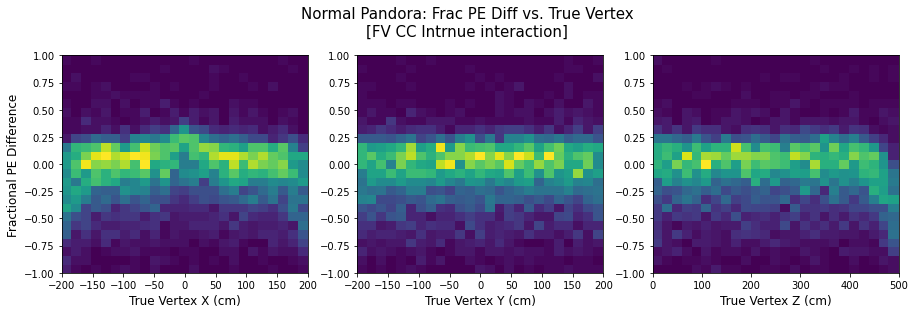

In [10]:
this_df = slc_opt0_nu_df.query("slc_tmatch_eff > 0.8")

fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist2d(this_df.position_x
           ,this_df.frac_pe
           ,bins=[np.linspace(-200,200,26),np.linspace(-1,1,26)]
        #    ,norm=mpl.colors.LogNorm()
           )
axes[1].hist2d(this_df.position_y
           ,this_df.frac_pe
           ,bins=[np.linspace(-200,200,26),np.linspace(-1,1,26)]
        #    ,norm=mpl.colors.LogNorm()
           )
axes[2].hist2d(this_df.position_z
           ,this_df.frac_pe
           ,bins=[np.linspace(0,500,26),np.linspace(-1,1,26)]
        #    ,norm=mpl.colors.LogNorm()
           )

axes[0].set_xlabel("True Vertex X (cm)", fontsize=12)
axes[1].set_xlabel("True Vertex Y (cm)", fontsize=12)
axes[2].set_xlabel("True Vertex Z (cm)", fontsize=12)

axes[0].set_ylabel("Fractional PE Difference", fontsize=12)
plt.suptitle("Normal Pandora: Frac PE Diff vs. True Vertex\n[FV CC Intrnue interaction]", fontsize=15, y=1.05)
plt.show()

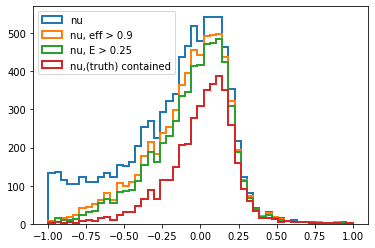

In [11]:
bins = np.linspace(-1,1,50)
this_nu = slc_opt0_nu_df.query("slc_tmatch_eff > 0.8").copy()
this_co = slc_opt0_co_df.copy()
plt.hist(slc_opt0_nu_df.frac_pe,
         bins=bins,histtype="step",lw=2,density=False,label="nu")
plt.hist(this_nu.frac_pe,
         bins=bins,histtype="step",lw=2,density=False,label="nu, eff > 0.9")
plt.hist(this_nu.query("total_prim_depE > 0.25").frac_pe,
         bins=bins,histtype="step",lw=2,density=False,label="nu, E > 0.25")
plt.hist(this_nu.query("prim_cont == True").frac_pe,
         bins=bins,histtype="step",lw=2,density=False,label="nu,(truth) contained")
# plt.hist(this_nu.query("abs(position_x) < 100").frac_pe,
#          bins=bins,histtype="step",lw=2,density=True,label="nu, x < 100")
plt.legend(loc="upper left")
plt.show()

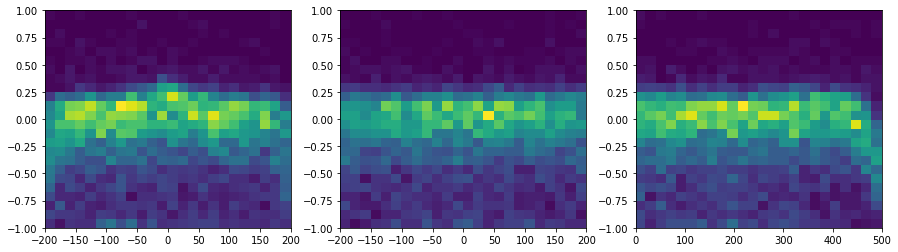

In [12]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist2d(slc_opt0_nu_df.position_x
           ,slc_opt0_nu_df.frac_pe
           ,bins=[np.linspace(-200,200,25),np.linspace(-1,1,25)]
        #    ,norm=mpl.colors.LogNorm()
           )
axes[1].hist2d(slc_opt0_nu_df.position_y
           ,slc_opt0_nu_df.frac_pe
           ,bins=[np.linspace(-200,200,25),np.linspace(-1,1,25)]
        #    ,norm=mpl.colors.LogNorm()
           )
axes[2].hist2d(slc_opt0_nu_df.position_z
           ,slc_opt0_nu_df.frac_pe
           ,bins=[np.linspace(0,500,25),np.linspace(-1,1,25)]
        #    ,norm=mpl.colors.LogNorm()
           )

plt.show()

## Study on neutrino events with very low completeness 

In [13]:
# select neutrino slices with very low frac_pe 
all_nu_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx != -999 & run>0 & signal < 2& iscc==1"  )
lo_nu_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx != -999 & run>0 & signal < 2 & frac_pe < -0.5 & iscc==1" )
hi_nu_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx != -999 & run>0 & signal < 2 & frac_pe > -0.5 & iscc==1" )

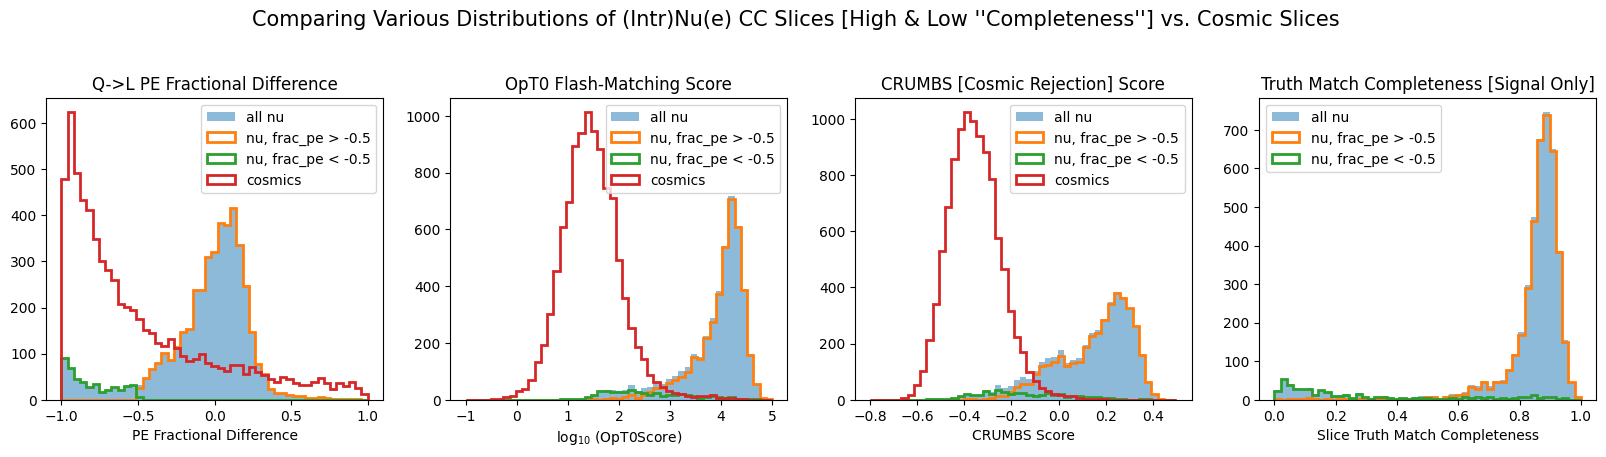

In [14]:
fig, axes = plt.subplots(1,4,figsize=(20,4),dpi=100)
normalized = False
# the problem is that the very low completeness will also often make the neutrino look like a cosmic 
axes[0].hist(all_nu_df.frac_pe,     bins=np.linspace(-1,1,50),lw=2,alpha=0.5,      density=normalized,label="all nu")
axes[0].hist(hi_nu_df.frac_pe,      bins=np.linspace(-1,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.5")
axes[0].hist(lo_nu_df.frac_pe,      bins=np.linspace(-1,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.5")
axes[0].hist(slc_opt0_co_df.frac_pe,bins=np.linspace(-1,1,50),lw=2,histtype="step",density=normalized,label="cosmics")
axes[0].set_xlabel('PE Fractional Difference')
# axes[0].set_ylabel("Area Normalized")
axes[0].set_title("Q->L PE Fractional Difference")
axes[0].legend()

axes[1].hist(np.log10(all_nu_df.score),     bins=np.linspace(-1,5,50),lw=2,alpha=0.5,      density=normalized,label="all nu")
axes[1].hist(np.log10(hi_nu_df.score),      bins=np.linspace(-1,5,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.5")
axes[1].hist(np.log10(lo_nu_df.score),      bins=np.linspace(-1,5,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.5")
axes[1].hist(np.log10(slc_opt0_co_df.score),bins=np.linspace(-1,5,50),lw=2,histtype="step",density=normalized,label="cosmics")
axes[1].set_xlabel(r"$\log_{10}$ (OpT0Score)")
axes[1].legend(loc="upper right")
axes[1].set_title("OpT0 Flash-Matching Score")
# axes[1].set_ylabel("Area Normalized")

axes[2].hist(all_nu_df.slc_crumbs_result_score,     bins=np.linspace(-0.8,0.5,50),lw=2,alpha=0.5,      density=normalized,label="all nu")
axes[2].hist(hi_nu_df.slc_crumbs_result_score,      bins=np.linspace(-0.8,0.5,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.5")
axes[2].hist(lo_nu_df.slc_crumbs_result_score,      bins=np.linspace(-0.8,0.5,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.5")
axes[2].hist(slc_opt0_co_df.slc_crumbs_result_score,bins=np.linspace(-0.8,0.5,50),lw=2,histtype="step",density=normalized,label="cosmics")
axes[2].set_xlabel(r"CRUMBS Score")
axes[2].set_title("CRUMBS [Cosmic Rejection] Score")
axes[2].legend(loc="upper right")
# axes[2].set_ylabel("Area Normalized")

axes[3].hist(all_nu_df.slc_tmatch_eff,     bins=np.linspace(0,1,50),lw=2,alpha=0.5,      density=normalized,label="all nu")
axes[3].hist(hi_nu_df.slc_tmatch_eff,      bins=np.linspace(0,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.5")
axes[3].hist(lo_nu_df.slc_tmatch_eff,      bins=np.linspace(0,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.5")
axes[3].set_xlabel(r"Slice Truth Match Completeness")
axes[3].set_title("Truth Match Completeness [Signal Only]")
axes[3].legend(loc="upper left")
# axes[3].set_ylabel("Area Normalized")
plt.suptitle("Comparing Various Distributions of (Intr)Nu(e) CC Slices [High & Low ''Completeness''] vs. Cosmic Slices",y=1.1,fontsize=15)
plt.show()

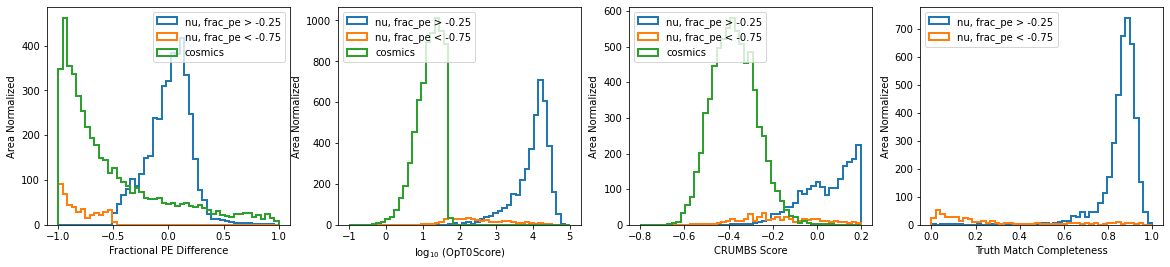

In [15]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
normalized = False
this_co_df = slc_opt0_co_df.query("score < 50 & slc_crumbs_result_score < 0.5")
# the problem is that the very low completeness will also often make the neutrino look like a cosmic 
axes[0].hist(hi_nu_df.frac_pe,      bins=np.linspace(-1,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.25")
axes[0].hist(lo_nu_df.frac_pe,      bins=np.linspace(-1,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.75")
axes[0].hist(this_co_df.frac_pe,bins=np.linspace(-1,1,50),lw=2,histtype="step",density=normalized,label="cosmics")
axes[0].set_xlabel('Fractional PE Difference')
axes[0].set_ylabel("Area Normalized")
axes[0].legend()

axes[1].hist(np.log10(hi_nu_df.score),      bins=np.linspace(-1,5,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.25")
axes[1].hist(np.log10(lo_nu_df.score),      bins=np.linspace(-1,5,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.75")
axes[1].hist(np.log10(this_co_df.score),bins=np.linspace(-1,5,50),lw=2,histtype="step",density=normalized,label="cosmics")
axes[1].set_xlabel(r"$\log_{10}$ (OpT0Score)")
axes[1].legend(loc="upper left")
axes[1].set_ylabel("Area Normalized")

axes[2].hist(hi_nu_df.slc_crumbs_result_score,      bins=np.linspace(-0.8,0.2,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.25")
axes[2].hist(lo_nu_df.slc_crumbs_result_score,      bins=np.linspace(-0.8,0.2,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.75")
axes[2].hist(this_co_df.slc_crumbs_result_score,bins=np.linspace(-0.8,0.2,50),lw=2,histtype="step",density=normalized,label="cosmics")
axes[2].set_xlabel(r"CRUMBS Score")
axes[2].legend(loc="upper left")
axes[2].set_ylabel("Area Normalized")

axes[3].hist(hi_nu_df.slc_tmatch_eff,      bins=np.linspace(0,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe > -0.25")
axes[3].hist(lo_nu_df.slc_tmatch_eff,      bins=np.linspace(0,1,50),lw=2,histtype="step",density=normalized,label="nu, frac_pe < -0.75")
axes[3].set_xlabel(r"Truth Match Completeness")
axes[3].legend(loc="upper left")
axes[3].set_ylabel("Area Normalized")
# plt.suptitle("Comparing Distributions")
plt.show()

In [16]:
print("percentage of signal nue slices with completeness below 0.5: ", len(all_nu_df.query("slc_tmatch_eff < 0.5"))/len(all_nu_df))
print("percentgae of slices with low completeness (<0.5) that have Fractional Diff < -0.5: ", len(all_nu_df.query("slc_tmatch_eff < 0.5 & frac_pe < -0.5"))/len(all_nu_df.query("slc_tmatch_eff < 0.5")))

percentage of signal nue slices with completeness below 0.5:  0.08879120879120879
percentgae of slices with low completeness (<0.5) that have Fractional Diff < -0.5:  0.8787128712871287


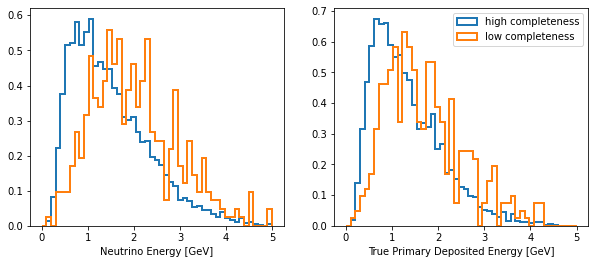

In [17]:
# what is the dependence of completeness on energy?

hi_complete_df = all_nu_df.query("slc_tmatch_eff > 0.8")
lo_complete_df = all_nu_df.query("slc_tmatch_eff < 0.5")

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist(hi_complete_df.E,              bins=np.linspace(0,5,50),histtype="step",lw=2,density=True,label="high completeness")
axes[0].hist(lo_complete_df.E,              bins=np.linspace(0,5,50),histtype="step",lw=2,density=True,label="low completeness")
axes[0].set_xlabel("Neutrino Energy [GeV]")
axes[1].hist(hi_complete_df.total_prim_depE,bins=np.linspace(0,5,50),histtype="step",lw=2,density=True,label="high completeness")
axes[1].hist(lo_complete_df.total_prim_depE,bins=np.linspace(0,5,50),histtype="step",lw=2,density=True,label="low completeness")
axes[1].set_xlabel("True Primary Deposited Energy [GeV]")
plt.legend()
plt.show()

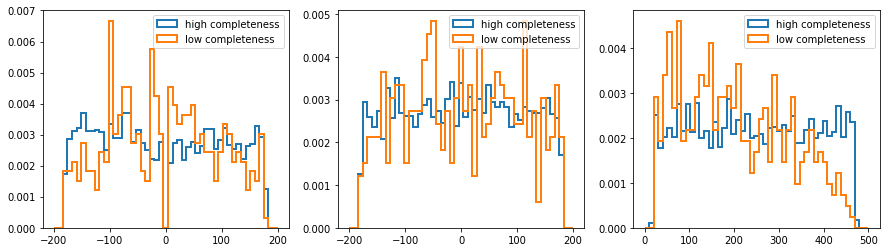

In [18]:
# what is the dependence of completeness on position? 
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist(hi_complete_df.position_x,bins=np.linspace(-200,200,50),histtype="step",lw=2,density=True,label="high completeness")
axes[0].hist(lo_complete_df.position_x,bins=np.linspace(-200,200,50),histtype="step",lw=2,density=True,label="low completeness")
axes[0].legend()

axes[1].hist(hi_complete_df.position_y,bins=np.linspace(-200,200,50),histtype="step",lw=2,density=True,label="high completeness")
axes[1].hist(lo_complete_df.position_y,bins=np.linspace(-200,200,50),histtype="step",lw=2,density=True,label="low completeness")
axes[1].legend()

axes[2].hist(hi_complete_df.position_z,bins=np.linspace(0,500,50),histtype="step",lw=2,density=True,label="high completeness")
axes[2].hist(lo_complete_df.position_z,bins=np.linspace(0,500,50),histtype="step",lw=2,density=True,label="low completeness")
axes[2].legend()
plt.show()

## Study on neutrino events with exiting primaries

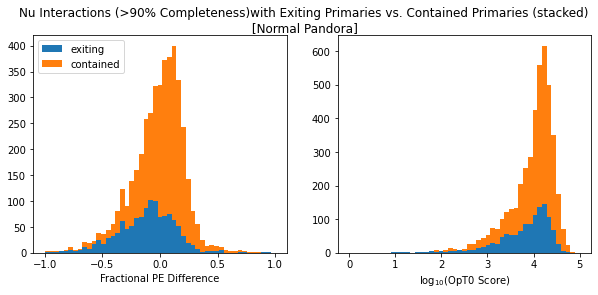

In [19]:
# this dataframe contains all slcs and all pfps (nu + cosmics )
slcpfp_nue_nu_df
# restrict to only neutrino slcs with high completeness 
slc_opt0_nu_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx != -999 & run>0 & (signal < 3) & slc_tmatch_eff > 0.80")
exit_slc_df = slc_opt0_nu_df.query("prim_cont == False")
cont_slc_df = slc_opt0_nu_df.query("prim_cont == True")
# plot what the frac pe distribution looks like in comparison between exiting and contained slcs
# compare the relative contributions of each population with a stacked histogram 
fig, axes = plt.subplots(1,2,figsize=(10,4))
bins = np.linspace(-1,1,50)
axes[0].hist([exit_slc_df.frac_pe,
          cont_slc_df.frac_pe],
          bins=bins,lw=2,label=["exiting","contained"],stacked=True)
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Fractional PE Difference")

axes[1].hist([np.log10(exit_slc_df.score),
              np.log10(cont_slc_df.score)],
              bins=np.linspace(0,5,50),lw=2,label=["exiting","contained"],stacked=True)
axes[1].set_xlabel(r"$\log_{10}$(OpT0 Score)")

plt.suptitle("Nu Interactions (>90% Completeness)with Exiting Primaries vs. Contained Primaries (stacked)\n [Normal Pandora]")
plt.show()

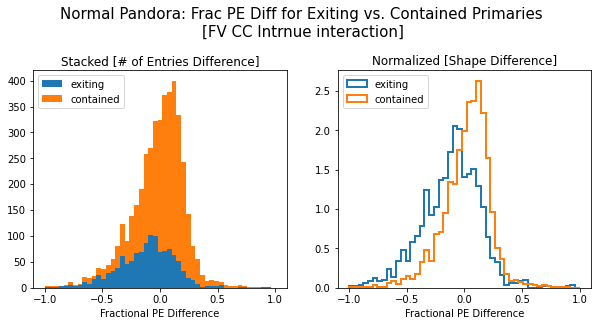

In [20]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
bins = np.linspace(-1,1,50)

axes[0].hist([exit_slc_df.frac_pe,
          cont_slc_df.frac_pe],
          bins=bins,lw=2,label=["exiting","contained"],stacked=True)
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Fractional PE Difference")
axes[0].set_title("Stacked [# of Entries Difference]")

axes[1].hist(exit_slc_df.frac_pe,bins=bins,density=True,lw=2,histtype="step",label="exiting")
axes[1].hist(cont_slc_df.frac_pe,bins=bins,density=True,lw=2,histtype="step",label="contained")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Fractional PE Difference")
axes[1].set_title("Normalized [Shape Difference]")

plt.suptitle("Normal Pandora: Frac PE Diff for Exiting vs. Contained Primaries \n[FV CC Intrnue interaction]", fontsize=15, y=1.1)
plt.show()